In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_regularization
from gaminet.utils import plot_trajectory

In [2]:
def load_ch(path="./", missing_strategy="drop"):
    
    from sklearn.datasets import fetch_california_housing
    cal_housing = fetch_california_housing()
    x, y = cal_housing.data, cal_housing.target.reshape(-1, 1)

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(x.shape[1])}
    meta_info.update({'Y':{'type':'target'}})         
    return x, y, task_type, meta_info

def load_classification_data(name):
    data_path = '.'
    func_dict = {'ch':load_ch}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_(data_path, missing_strategy="impute")
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                sy = MinMaxScaler((0, 1))
                y = sy.fit_transform(y)
                meta_info[key]['scaler'] = sy
            elif item['type'] == 'categorical':
                enc = OrdinalEncoder()
                xx[:,[i]] = enc.fit_transform(x[:,[i]])
                meta_info[key]['values'] = []
                for item in enc.categories_[0].tolist():
                    try:
                        if item == int(item):
                            meta_info[key]['values'].append(str(int(item)))
                        else:
                            meta_info[key]['values'].append(str(item))
                    except ValueError:
                        meta_info[key]['values'].append(str(item))
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info
    return wrapper

In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def mse(label, pred, scaler=None):
    return mean_squared_error(label, pred)

get_metric = metric_wrapper(mse, None)

In [4]:
random_state = 0
data_loader = load_classification_data("ch")
train_x, test_x, train_y, test_y, task_type, meta_info = data_loader(random_state)

In [6]:
meta_info.keys()

dict_keys(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y'])

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.04555, val loss: 0.04548
Main effects training epoch: 2, train loss: 0.03338, val loss: 0.03305
Main effects training epoch: 3, train loss: 0.02789, val loss: 0.02807
Main effects training epoch: 4, train loss: 0.02478, val loss: 0.02531
Main effects training epoch: 5, train loss: 0.02353, val loss: 0.02421
Main effects training epoch: 6, train loss: 0.02296, val loss: 0.02366
Main effects training epoch: 7, train loss: 0.02260, val loss: 0.02328
Main effects training epoch: 8, train loss: 0.02232, val loss: 0.02300
Main effects training epoch: 9, train loss: 0.02210, val loss: 0.02277
Main effects training epoch: 10, train loss: 0.02188, val loss: 0.02252
Main effects training epoch: 11, train loss: 0.02169, val loss: 0.02231
Main effects training epoch: 12, train loss: 0.02151, val loss: 0.02213
Main effects training e

Main effects training epoch: 114, train loss: 0.01727, val loss: 0.01881
Main effects training epoch: 115, train loss: 0.01731, val loss: 0.01889
Main effects training epoch: 116, train loss: 0.01729, val loss: 0.01878
Main effects training epoch: 117, train loss: 0.01735, val loss: 0.01891
Main effects training epoch: 118, train loss: 0.01727, val loss: 0.01881
Main effects training epoch: 119, train loss: 0.01731, val loss: 0.01886
Main effects training epoch: 120, train loss: 0.01728, val loss: 0.01883
Main effects training epoch: 121, train loss: 0.01728, val loss: 0.01885
Main effects training epoch: 122, train loss: 0.01727, val loss: 0.01882
Main effects training epoch: 123, train loss: 0.01727, val loss: 0.01882
Main effects training epoch: 124, train loss: 0.01730, val loss: 0.01887
Main effects training epoch: 125, train loss: 0.01730, val loss: 0.01882
Main effects training epoch: 126, train loss: 0.01729, val loss: 0.01887
Main effects training epoch: 127, train loss: 0.017

Interaction training epoch: 96, train loss: 0.01569, val loss: 0.01700
Interaction training epoch: 97, train loss: 0.01568, val loss: 0.01699
Interaction training epoch: 98, train loss: 0.01566, val loss: 0.01698
Interaction training epoch: 99, train loss: 0.01568, val loss: 0.01700
Interaction training epoch: 100, train loss: 0.01569, val loss: 0.01703
Interaction training epoch: 101, train loss: 0.01567, val loss: 0.01699
Interaction training epoch: 102, train loss: 0.01566, val loss: 0.01700
Interaction training epoch: 103, train loss: 0.01564, val loss: 0.01696
Interaction training epoch: 104, train loss: 0.01565, val loss: 0.01697
Interaction training epoch: 105, train loss: 0.01564, val loss: 0.01695
Interaction training epoch: 106, train loss: 0.01566, val loss: 0.01697
Interaction training epoch: 107, train loss: 0.01564, val loss: 0.01699
Interaction training epoch: 108, train loss: 0.01563, val loss: 0.01696
Interaction training epoch: 109, train loss: 0.01563, val loss: 0.01

Fine tuning epoch: 35, train loss: 0.01524, val loss: 0.01665
Fine tuning epoch: 36, train loss: 0.01523, val loss: 0.01665
Fine tuning epoch: 37, train loss: 0.01522, val loss: 0.01664
Fine tuning epoch: 38, train loss: 0.01522, val loss: 0.01662
Fine tuning epoch: 39, train loss: 0.01522, val loss: 0.01663
Fine tuning epoch: 40, train loss: 0.01521, val loss: 0.01662
Fine tuning epoch: 41, train loss: 0.01522, val loss: 0.01662
Fine tuning epoch: 42, train loss: 0.01520, val loss: 0.01660
Fine tuning epoch: 43, train loss: 0.01519, val loss: 0.01659
Fine tuning epoch: 44, train loss: 0.01519, val loss: 0.01659
Fine tuning epoch: 45, train loss: 0.01518, val loss: 0.01659
Fine tuning epoch: 46, train loss: 0.01518, val loss: 0.01659
Fine tuning epoch: 47, train loss: 0.01517, val loss: 0.01658
Fine tuning epoch: 48, train loss: 0.01517, val loss: 0.01657
Fine tuning epoch: 49, train loss: 0.01517, val loss: 0.01657
Fine tuning epoch: 50, train loss: 0.01516, val loss: 0.01656
Fine tun

Fine tuning epoch: 167, train loss: 0.01493, val loss: 0.01634
Fine tuning epoch: 168, train loss: 0.01493, val loss: 0.01634
Fine tuning epoch: 169, train loss: 0.01493, val loss: 0.01633
Fine tuning epoch: 170, train loss: 0.01493, val loss: 0.01634
Fine tuning epoch: 171, train loss: 0.01492, val loss: 0.01633
Fine tuning epoch: 172, train loss: 0.01492, val loss: 0.01633
Fine tuning epoch: 173, train loss: 0.01492, val loss: 0.01633
Fine tuning epoch: 174, train loss: 0.01492, val loss: 0.01632
Fine tuning epoch: 175, train loss: 0.01492, val loss: 0.01633
Fine tuning epoch: 176, train loss: 0.01492, val loss: 0.01632
Fine tuning epoch: 177, train loss: 0.01492, val loss: 0.01633
Fine tuning epoch: 178, train loss: 0.01492, val loss: 0.01633
Fine tuning epoch: 179, train loss: 0.01491, val loss: 0.01632
Fine tuning epoch: 180, train loss: 0.01491, val loss: 0.01632
Fine tuning epoch: 181, train loss: 0.01491, val loss: 0.01632
Fine tuning epoch: 182, train loss: 0.01491, val loss: 

Fine tuning epoch: 298, train loss: 0.01483, val loss: 0.01616
Fine tuning epoch: 299, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 300, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 301, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 302, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 303, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 304, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 305, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 306, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 307, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 308, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 309, train loss: 0.01483, val loss: 0.01614
Fine tuning epoch: 310, train loss: 0.01483, val loss: 0.01614
Fine tuning epoch: 311, train loss: 0.01483, val loss: 0.01615
Fine tuning epoch: 312, train loss: 0.01483, val loss: 0.01614
Fine tuning epoch: 313, train loss: 0.01483, val loss: 

Fine tuning epoch: 429, train loss: 0.01480, val loss: 0.01610
Fine tuning epoch: 430, train loss: 0.01480, val loss: 0.01610
Fine tuning epoch: 431, train loss: 0.01480, val loss: 0.01610
Fine tuning epoch: 432, train loss: 0.01480, val loss: 0.01610
Fine tuning epoch: 433, train loss: 0.01480, val loss: 0.01610
Fine tuning epoch: 434, train loss: 0.01480, val loss: 0.01609
Fine tuning epoch: 435, train loss: 0.01480, val loss: 0.01610
Fine tuning epoch: 436, train loss: 0.01479, val loss: 0.01609
Fine tuning epoch: 437, train loss: 0.01480, val loss: 0.01610
Fine tuning epoch: 438, train loss: 0.01480, val loss: 0.01609
Fine tuning epoch: 439, train loss: 0.01479, val loss: 0.01609
Fine tuning epoch: 440, train loss: 0.01480, val loss: 0.01611
Fine tuning epoch: 441, train loss: 0.01480, val loss: 0.01609
Fine tuning epoch: 442, train loss: 0.01479, val loss: 0.01610
Fine tuning epoch: 443, train loss: 0.01480, val loss: 0.01609
Fine tuning epoch: 444, train loss: 0.01479, val loss: 

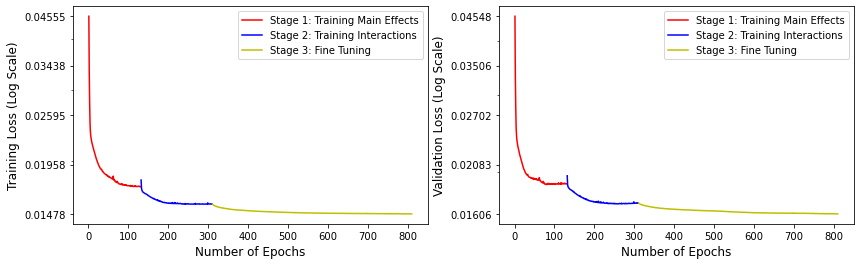

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


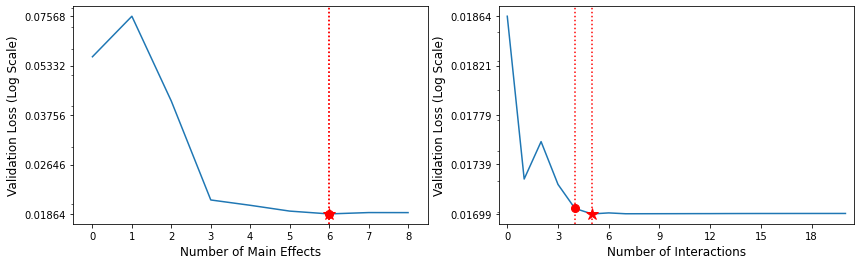

In [7]:
folder = "./results/"
if not os.path.exists(folder):
    os.makedirs(folder)

model = GAMINet(meta_info={"X" + str(i + 1):item for i, item in enumerate(meta_info.values())}, interact_num=20,
            interact_arch=[40] * 5, subnet_arch=[40] * 5, 
            batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, 
            lr_bp=[0.001, 0.001, 0.0001], early_stop_thres=[50, 50, 50],
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            mono_increasing_list=[0, 1, 2, 4],
            mono_decreasing_list=[3, 5, 6, 7],
            verbose=True, val_ratio=0.2, random_state=0)
model.fit(train_x, train_y)
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="ch_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="ch_regu", save_png=True, save_eps=True)

In [8]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.01504 0.01565]


In [9]:
gaminet_stat = np.hstack([np.round(np.mean(train_y == (pred_train > 0.5)),5),
                          np.round(np.mean(test_y == (pred_test > 0.5)),5)])
print(gaminet_stat)

[0.04482 0.04142]


Global Interpretation

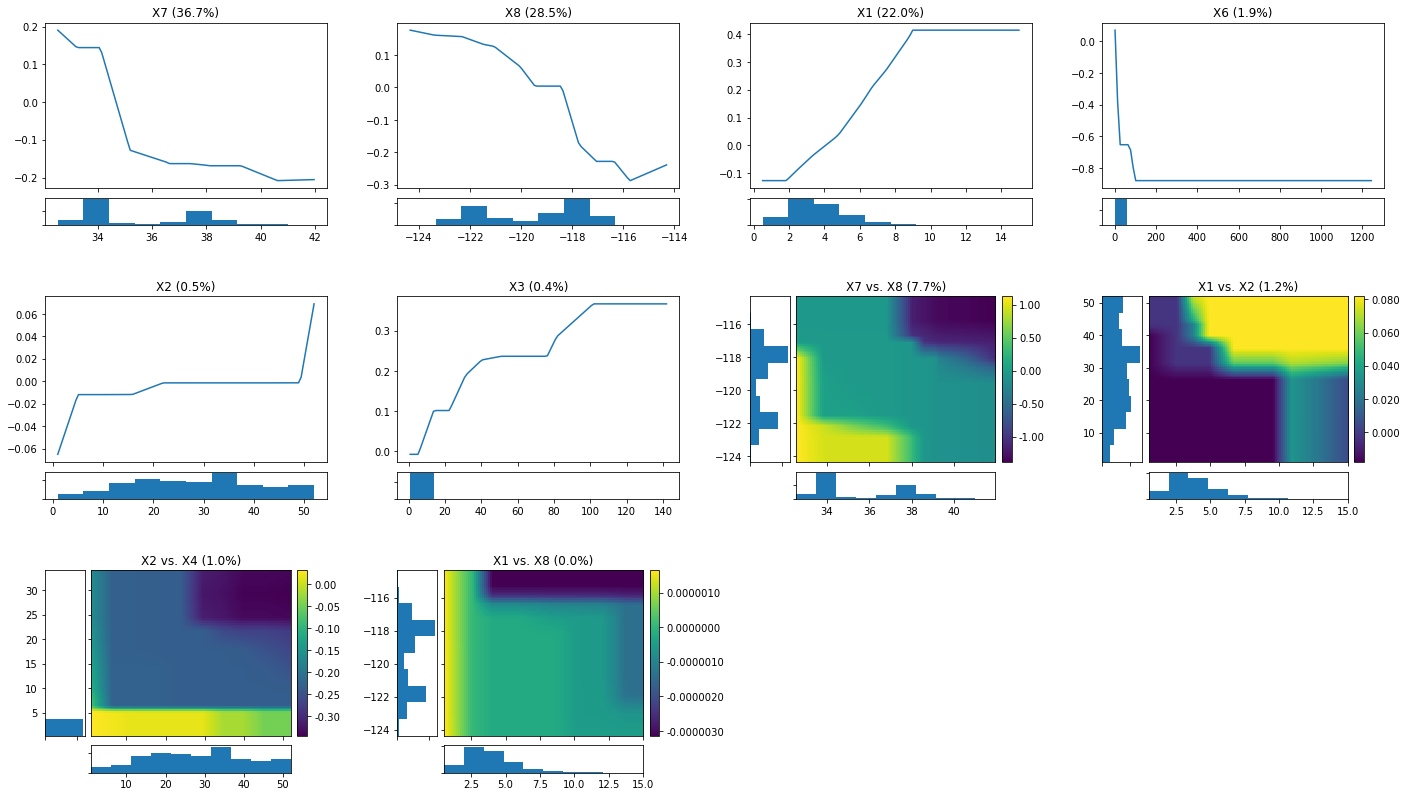

In [10]:
data_dict_global = model.global_explain(save_dict=True, folder=folder, name="ch_global")
global_visualize_density(data_dict_global, folder=folder, name="ch_global",  #11, 13, 19, 20
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

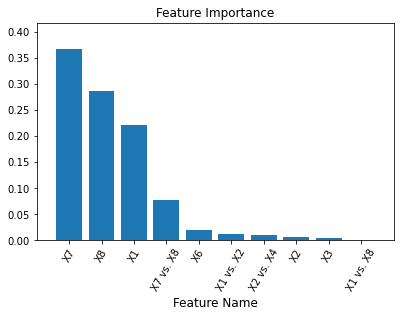

In [11]:
feature_importance_visualize(data_dict_global)

Interpret the prediction of a test sample

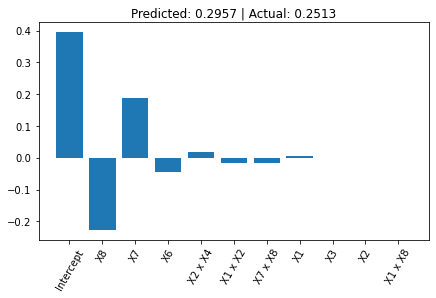

In [12]:
data_dict_local = model.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)